In [143]:
import os
import sys
import math
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import h3pandas
import momepy as mm
# import aceso
import shapely
import osmnx as ox
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..')
sys.path.append(PROJECT_SRC_PATH)

from transit_access import network, score



In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Transit connectivity

In [3]:
with open('../data/transit-network-connectivity-berlin.pkl', 'rb') as f:
    centraliy_G = pickle.load(f)

# plot_graph(centraliy_G, add_noise=False)

### Visual inspection of transit network from GTFS files

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' s

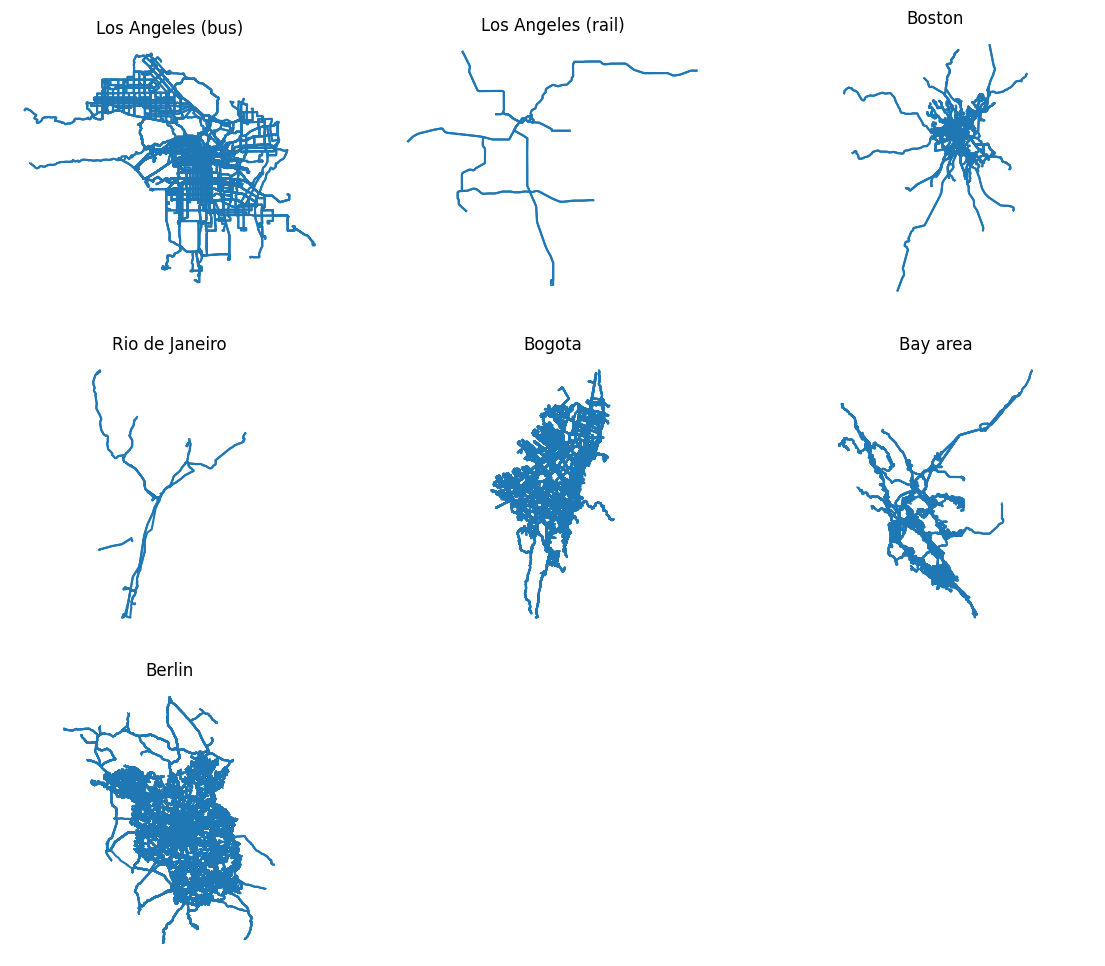

In [4]:

gtfs_paths = {
    'Los Angeles (bus)': '../data/gtfs_feeds/lax-gtfs_bus', 
    'Los Angeles (rail)': '../data/gtfs_feeds/lax-gtfs_rail',
    'Boston': '../data/gtfs_feeds/bos-MBTA_GTFS',
    'Rio de Janeiro': '../data/gtfs_feeds/rio-gtfs',
    'Bogota': '../data/gtfs_feeds/bog-GTFS-2023-10-01',
    'Bay area': '../data/gtfs_feeds/sfo-GTFSTransitData_RG',
    'Berlin': '../data/gtfs_feeds/ber-gtfs',
}

%matplotlib inline
ncols = 3
nrows = math.ceil(len(gtfs_paths.values()) / ncols)
_, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14, nrows * 4))

for i, (name, path) in enumerate(gtfs_paths.items()):
    feed = transit_access.network._get_busiest_feed(path)
    ax = axs[math.floor(i / ncols), i % ncols]
    feed.shapes.plot(ax=ax)
    ax.set_axis_off()
    ax.set_title(name)


for ax in axs.ravel():
    ax.set_axis_off()

### Creating transit graph and calculating closeness centrality for transit station

In [36]:
import transit_access.network

config = [
    {
        'city': 'Berlin',
        'gtfs_path': ['../data/gtfs_feeds/ber-gtfs'],
        'crs': 'EPSG:25833',
        'boundary_path': '../data/bounds/ber_bound.gpkg',
        'route_types': [109, 400, 700, 900]
    },
    {
        'city': 'Bogota',
        'gtfs_path': ['../data/gtfs_feeds/bog-GTFS-2023-10-01'],
        'crs': 'EPSG:21897',
        'boundary_path': '../data/bounds/bog_bound.gpkg',
    },
    {
        'city': 'Boston',
        'gtfs_path': ['../data/gtfs_feeds/bos-MBTA_GTFS'],
        'crs': 'EPSG:26914',
        'boundary_path': '../data/bounds/bos_bound.gpkg',
    },
    {
        'city': 'LAX',
        'gtfs_path': ['../data/gtfs_feeds/lax-gtfs_rail', '../data/gtfs_feeds/lax-gtfs_bus'],
        'crs': 'EPSG:26914',
        'boundary_path': '../data/bounds/lax_bound.gpkg',
    },
    {
        'city': 'SF',
        'gtfs_path': ['../data/gtfs_feeds/sfo-GTFSTransitData_RG'],
        'crs': 'EPSG:26914',
        'boundary_path': '../data/bounds/sfo_bound.gpkg',
    },
    {
        'city': 'Rio',
        'gtfs_path': ['../data/gtfs_feeds/rio-gtfs'],
        'crs': 'EPSG:5641',
        'boundary_path': '../data/bounds/rio_bound.gpkg',
    }
]

start_time = '06:00'
end_time = '10:00'

for conf in config:
    boundary = gpd.read_file(conf['boundary_path']).dissolve().to_crs(conf['crs']).geometry[0]
    G = transit_access.network.transit_graph(conf['gtfs_path'], conf['crs'], start_time=start_time, end_time=end_time, route_types=conf.get('route_types'), boundary=boundary, frac=0.2)
    
    # with open('../data/transit-network-connectivity-SF.pkl', 'wb') as handle:
    #     pickle.dump(G, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # plot_network_centrality(G)



2023-08-16 11:29:40,458 | INFO | STEP 1/12 - Loading GTFS feed(s) ...
2023-08-16 11:30:04,693 | INFO | STEP 2/12 - Combining GTFS feeds ...
2023-08-16 11:30:22,890 | INFO | STEP 3/12 - Creating unique stop ids per route...


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2023-08-16 11:30:24,737 | INFO | STEP 4/12 - Filtering transit service between 06:00 and 10:00...
2023-08-16 11:30:25,035 | INFO | STEP 5/12 - Approximating transfer waiting times...
2023-08-16 11:30:25,607 | INFO | STEP 6/12 - Calculating travel times between stops...
2023-08-16 11:30:25,978 | INFO | STEP 7/12 - Projecting transit stop locations to local, metric coordinate system (EPSG:25833)...
2023-08-16 11:30:26,344 | INFO | STEP 8a/12 - Filtering by geographical boundary...
2023-08-16 11:30:45,706 | INFO | STEP 8b/12 - Filtering by transit service types ([109, 400, 700, 900])...
2023-08-16 11:30:45,808 | INFO | STEP 8c/12 - Sampling 20.0% of all transit routes...
2023-08-16 11:30:45,939 | INFO | STEP 9/12 - Creating NetworkX graph...
2023-08-16 11:30:46,805 | INFO | STEP 10/12 - Adding edges for walk transfers between stops no more than 200 m apart (assuming walk speed of 4 km/h)...
2023-08-16 11:30:46,876 | INFO | STEP 11/12 - Calculating global closeness centrality based on trav

In [93]:
with open('../data/transit-network-connectivity-berlin.pkl', 'rb') as f:
    G_ber = pickle.load(f)

with open('../data/transit-network-connectivity-bogota.pkl', 'rb') as f:
    G_bog = pickle.load(f)

with open('../data/transit-network-connectivity-boston.pkl', 'rb') as f:
    G_bos = pickle.load(f)

with open('../data/transit-network-connectivity-SF.pkl', 'rb') as f:
    G_sf = pickle.load(f)

with open('../data/transit-network-connectivity-LAX.pkl', 'rb') as f:
    G_lax = pickle.load(f)

In [145]:
# with open('../data/transit-network-connectivity-SF-20230816-05-42-23-local-centrality.pkl', 'rb') as f:
#     G_sf_local = pickle.load(f)

# with open('../data/transit-network-connectivity-Rio-20230816-05-59-55-local-centrality.pkl', 'rb') as f:
#     G_rio_local = pickle.load(f)

# with open('../data/transit-network-connectivity-LAX-20230816-05-42-23-local-centrality.pkl', 'rb') as f:
#     G_lax_local = pickle.load(f)

score_sf = pd.read_pickle('../data/access-score-grid-SF-20230818-02-36-01.pkl')
score_rio = pd.read_pickle('../data/access-score-grid-Rio-20230818-02-41-11.pkl')
score_lax = pd.read_pickle('../data/access-score-grid-LAX-20230818-00-23-40.pkl')


In [ ]:
nodes_to_gdf(G_sf_local).explore()

In [146]:
score_rio.h3.h3_to_parent_aggregate(8, operation='mean').explore('access_score')
# score_lax.explore('access_score')

: 

In [90]:
gpd.read_file('/Users/fnachtigall/Downloads/boundaries_gpkg/Clermont.gpkg')

crs                                           geometry
0  3035  POLYGON ((3776195.378 2548934.425, 3776196.107...

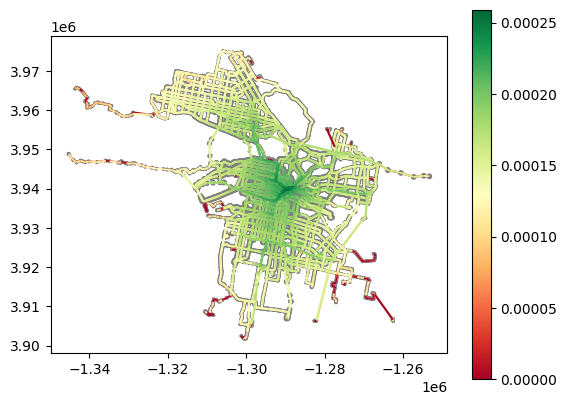

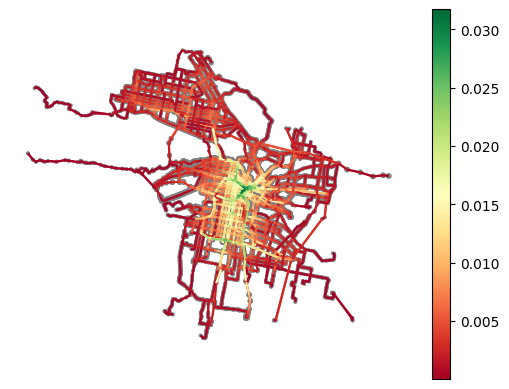

In [43]:
from shapely.geometry import LineString
from shapely.geometry import Point

def nodes_to_gdf(G):
    crs = G.graph['crs']
    nodes, data = zip(*G.nodes(data=True))

    geom = [Point(d['x'], d['y']) for d in data]
    gdf = gpd.GeoDataFrame(data, index=nodes, geometry=geom, crs=crs)

    return gdf


def edges_to_df(G):
    if G.is_multigraph():
        raise Exception('This function does not support multigraphs.')

    u, v, data = zip(*G.edges(data=True))
    index = pd.MultiIndex.from_arrays([u, v], names=['u', 'v'])
    df = pd.DataFrame(data, index=index)
    
    return df


def edges_to_gdf(G):
    crs = G.graph['crs']
    df = edges_to_df(G)
    nodes_x = nx.get_node_attributes(G, 'x')
    nodes_y = nx.get_node_attributes(G, 'y')
    geom = [LineString((Point((nodes_x[u], nodes_y[u])), Point((nodes_x[v], nodes_y[v])))) for u, v in df.index]
    gdf = gpd.GeoDataFrame(df, geometry=geom, crs=crs)

    return gdf

def graph_to_gdfs(G):
    return nodes_to_gdf(G), edges_to_gdf(G)

# graph_to_gdfs(nx.DiGraph(G_lax_local))
plot_network_centrality(G_rio_local)



In [62]:
1 / 50

0.02

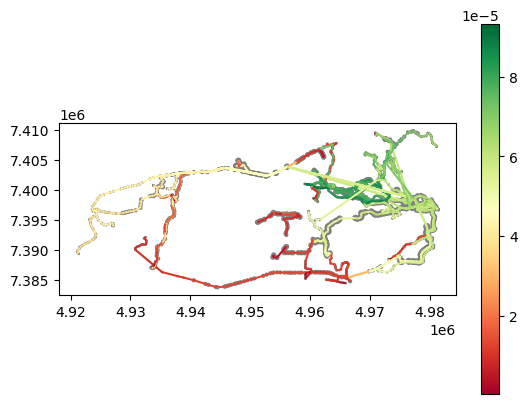

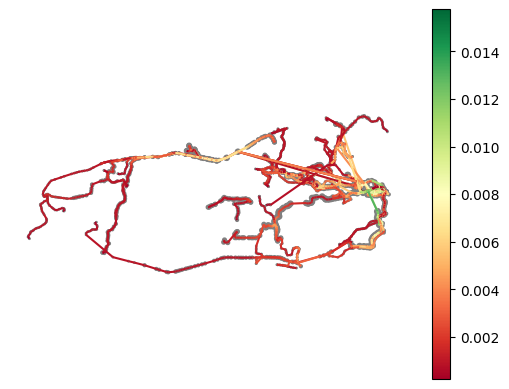

In [66]:
plot_network_centrality(G_rio_local)

In [79]:
edges = edges_to_df(nx.DiGraph(G_rio_local))
edges

weight  \
u                                       v                                                      
100309-056A-100309-O0878AAV0A-0         100309-4127O00005C0-100309-O0878AAV0A-0   183.000000   
100309-4127O00005C0-100309-O0878AAV0A-0 100309-4127O00112C0-100309-O0878AAV0A-0   168.000000   
100309-1001O00006C0-100309-E2018AAA0A-0 100309-1002O00007C0-100309-E2018AAA0A-0    23.500000   
100309-1002O00007C0-100309-E2018AAA0A-0 100309-1005O00140C0-100309-E2018AAA0A-0    20.500000   
100309-1005O00140C0-100309-E2018AAA0A-0 100309-1005O00090C0-100309-E2018AAA0A-0    63.750000   
...                                                                                      ...   
100309-5162O00022C0-100309-O0752AAA0A-0 100309-5162O00022C0-100309-O0388AAA0A-0  3993.000000   
100309-9FFM-100309-O0878AAV0A-0         100309-4127O00114C0-100309-O0878AAV0A-0    64.000000   
100309-T6H9-100309-E2110AAA0A-0         100309-4116O00015C0-100309-E2110AAA0A-0    70.666667   
                                        100309-4116O00026C0-100309-O0878AAV0A-0  1775.407521   
100309-ID2U-100309-O0878AAV0A-0         100309-4115O00124C0-100309-O0878AAV0A-0    69.000000   

                                                                                 mode  
u                                       v                                              
100309-056A-100309-O0878AAV0A-0         100309-4127O00005C0-100309-O0878AAV0A-0   NaN  
100309-4127O00005C0-100309-O0878AAV0A-0 100309-4127O00112C0-100309-O0878AAV0A-0   NaN  
100309-1001O00006C0-100309-E2018AAA0A-0 100309-1002O00007C0-100309-E2018AAA0A-0   NaN  
100309-1002O00007C0-100309-E2018AAA0A-0 100309-1005O00140C0-100309-E2018AAA0A-0   NaN  
100309-1005O00140C0-100309-E2018AAA0A-0 100309-1005O00090C0-100309-E2018AAA0A-0   NaN  
...                                                                               ...  
100309-5162O00022C0-100309-O0752AAA0A-0 100309-5162O00022C0-100309-O0388AAA0A-0  walk  
100309-9FFM-100309-O0878AAV0A-0         100309-4127O00114C0-100309-O0878AAV0A-0   NaN  
100309-T6H9-100309-E2110AAA0A-0         100309-4116O00015C0-100309-E2110AAA0A-0   NaN  
                                        100309-4116O00026C0-100309-O0878AAV0A-0  walk  
100309-ID2U-100309-O0878AAV0A-0         100309-4115O00124C0-100309-O0878AAV0A-0   NaN  

[5919 rows x 2 columns]

In [76]:
G_new2 = mm.closeness_centrality(G_rio_local, name='closeness_centrality', radius=1000, weight='weight', distance='weight')
plot_network_centrality(G_new2)

  0%|          | 0/2099 [00:00<?, ?it/s]

  0%|          | 0/2099 [00:00<?, ?it/s]

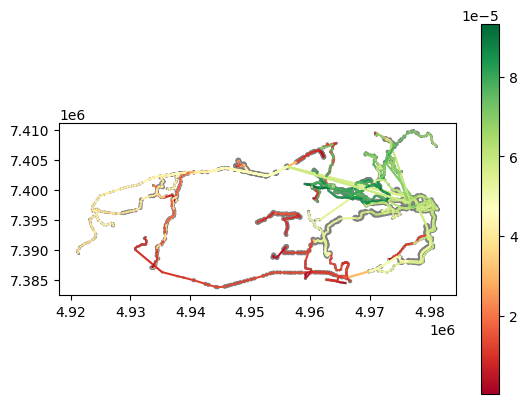

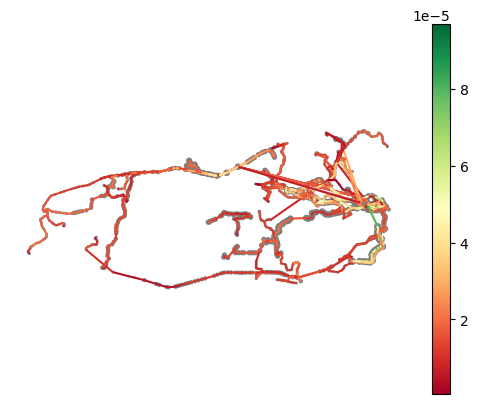

In [63]:
G_new2 = mm.closeness_centrality(G_rio_local.reverse(), name='closeness_centrality', radius=3000, weight='weight', distance='weight')
plot_network_centrality(G_new2)

In [72]:
1 / 1000

0.001

In [71]:
G_new2 = mm.closeness_centrality(G_lax_local.reverse(), name='closeness_centrality', radius=1000, weight='weight', distance='weight')
%matplotlib qt
plot_network_centrality(G_new2)

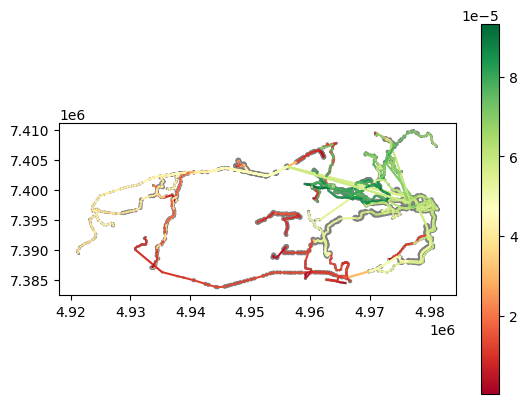

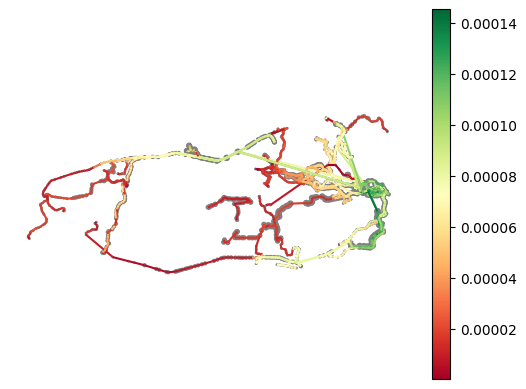

In [59]:
# G_new = mm.closeness_centrality(G_rio_local.reverse(), name='closeness_centrality', radius=100, weight='weight')
plot_network_centrality(G_new)

  0%|          | 0/2099 [00:00<?, ?it/s]

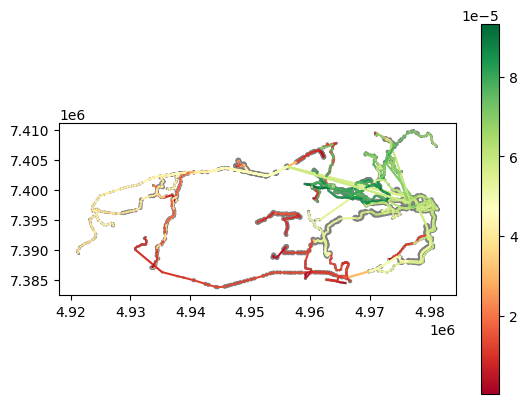

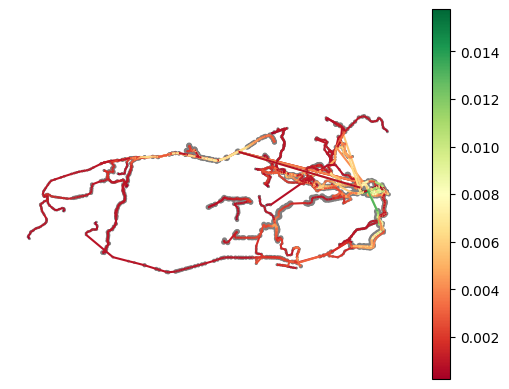

In [52]:
G_new = mm.closeness_centrality(G_rio_local.reverse(), name='closeness_centrality', radius=1000, weight='weight', distance='weight')
plot_network_centrality(G_new)

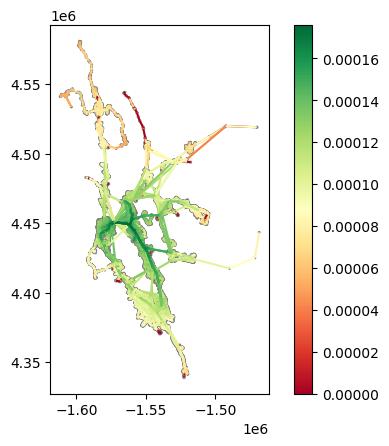

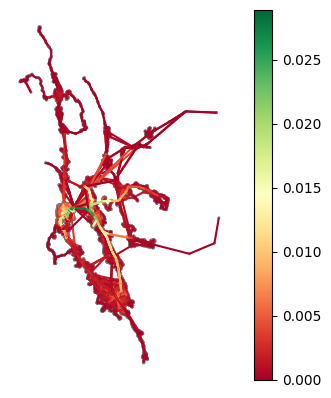

In [45]:
plot_network_centrality(G_sf_local)

In [18]:
# # plot_network_centrality(G_rio_local)
nodes, edges = mm.nx_to_gdf(G_rio_local)
# # G_rio_local.nodes(data=True)
# nodes
# stops = pd.DataFrame.from_dict(dict(G_rio_local.nodes(data=True)), orient='index')
# stops

# gpd.GeoDataFrame.from_dict(dict(G_rio_local.nodes(data=True)), orient='index', crs=G_rio_local.graph['crs']).plot('closeness_centrality')
pd.DataFrame.from_dict(dict(G_rio_local.nodes(data=True)), orient='index')

# a = [{'y': 7388333,
#   'x': 4963370,
# #   'headaway': 3350.0,
# #   'route_id': '100309-O0878AAV0A',
# #   'route_type': 700,
# #   'route_short_name': 'SV878',
# #   'centrality': 1.2218203315274671e-05,
# #   'n_departures': 2,
# #   'local_centrality': 0.001800061648392322,
#   'nodeID': 0},
#  {'y': 7387725,
#   'x': 4963434,
# #   'headaway': 3334.0,
# #   'route_id': '100309-O0878AAV0A',
# #   'route_type': 700,
# #   'route_short_name': 'SV878',
# #   'centrality': 1.2619367442970064e-05,
# #   'n_departures': 2,
# #   'local_centrality': 0.0014913704404842599,
#   'nodeID': 1},
#  {'y': 7398588,
#   'x': 4979154,
# #   'headaway': 3610.6666666666665,
# #   'route_id': '100309-E2018AAA0A',
# #   'route_type': 200,
# #   'route_short_name': '2018',
# #   'centrality': 5.9052491821811836e-05,
# #   'n_departures': 4,
# #   'local_centrality': 0.0019742828667995496,
#   'nodeID': 2}]

# pd.DataFrame.from_dict(a)

y             x  \
100309-056A-100309-O0878AAV0A-0          7.388334e+06  4.963371e+06   
100309-4127O00005C0-100309-O0878AAV0A-0  7.387725e+06  4.963435e+06   
100309-1001O00006C0-100309-E2018AAA0A-0  7.398589e+06  4.979155e+06   
100309-1002O00007C0-100309-E2018AAA0A-0  7.398458e+06  4.979115e+06   
100309-1005O00140C0-100309-E2018AAA0A-0  7.398330e+06  4.979125e+06   
...                                               ...           ...   
100309-5162O00022C0-100309-O0752AAA0A-0  7.403656e+06  4.945764e+06   
100309-3104O00023C0-100309-O0915AAA0A-0  7.409302e+06  4.970956e+06   
100309-9FFM-100309-O0878AAV0A-0          7.389190e+06  4.963172e+06   
100309-T6H9-100309-E2110AAA0A-0          7.390882e+06  4.962759e+06   
100309-ID2U-100309-O0878AAV0A-0          7.389614e+06  4.962517e+06   

                                            headaway           route_id  \
100309-056A-100309-O0878AAV0A-0          3350.000000  100309-O0878AAV0A   
100309-4127O00005C0-100309-O0878AAV0A-0  3334.000000  100309-O0878AAV0A   
100309-1001O00006C0-100309-E2018AAA0A-0  3610.666667  100309-E2018AAA0A   
100309-1002O00007C0-100309-E2018AAA0A-0  3610.666667  100309-E2018AAA0A   
100309-1005O00140C0-100309-E2018AAA0A-0  3610.666667  100309-E2018AAA0A   
...                                              ...                ...   
100309-5162O00022C0-100309-O0752AAA0A-0  2400.000000  100309-O0752AAA0A   
100309-3104O00023C0-100309-O0915AAA0A-0  6563.000000  100309-O0915AAA0A   
100309-9FFM-100309-O0878AAV0A-0          3388.000000  100309-O0878AAV0A   
100309-T6H9-100309-E2110AAA0A-0          1903.800000  100309-E2110AAA0A   
100309-ID2U-100309-O0878AAV0A-0          3414.000000  100309-O0878AAV0A   

                                         route_type route_short_name  \
100309-056A-100309-O0878AAV0A-0                 700            SV878   
100309-4127O00005C0-100309-O0878AAV0A-0         700            SV878   
100309-1001O00006C0-100309-E2018AAA0A-0         200             2018   
100309-1002O00007C0-100309-E2018AAA0A-0         200             2018   
100309-1005O00140C0-100309-E2018AAA0A-0         200             2018   
...                                             ...              ...   
100309-5162O00022C0-100309-O0752AAA0A-0         700              752   
100309-3104O00023C0-100309-O0915AAA0A-0         700              915   
100309-9FFM-100309-O0878AAV0A-0                 700            SV878   
100309-T6H9-100309-E2110AAA0A-0                 200             2110   
100309-ID2U-100309-O0878AAV0A-0                 700            SV878   

                                         centrality  n_departures  \
100309-056A-100309-O0878AAV0A-0            0.000012             2   
100309-4127O00005C0-100309-O0878AAV0A-0    0.000013             2   
100309-1001O00006C0-100309-E2018AAA0A-0    0.000059             4   
100309-1002O00007C0-100309-E2018AAA0A-0    0.000059             4   
100309-1005O00140C0-100309-E2018AAA0A-0    0.000059             4   
...                                             ...           ...   
100309-5162O00022C0-100309-O0752AAA0A-0    0.000045             2   
100309-3104O00023C0-100309-O0915AAA0A-0    0.000000             2   
100309-9FFM-100309-O0878AAV0A-0            0.000049             2   
100309-T6H9-100309-E2110AAA0A-0            0.000057             6   
100309-ID2U-100309-O0878AAV0A-0            0.000049             2   

                                         local_centrality  
100309-056A-100309-O0878AAV0A-0                  0.001800  
100309-4127O00005C0-100309-O0878AAV0A-0          0.001491  
100309-1001O00006C0-100309-E2018AAA0A-0          0.001974  
100309-1002O00007C0-100309-E2018AAA0A-0          0.001770  
100309-1005O00140C0-100309-E2018AAA0A-0          0.001663  
...                                                   ...  
100309-5162O00022C0-100309-O0752AAA0A-0          0.006667  
100309-3104O00023C0-100309-O0915AAA0A-0          0.001082  
100309-9FFM-100309-O0878AAV0A-0                  0.002300  
1003

In [38]:
import momepy as mm
# plot_network_centrality(G)
# # local_centrality = nx.closeness_centrality(G.reverse(), distance='weight', wf_improved=True)
# # nx.set_node_attributes(G, centrality, 'centrality')

# G_new = mm.closeness_centrality(G.reverse(), radius=3000, distance='weight')
G_new = mm.closeness_centrality(G_new, name='global_centrality', distance='weight')
# plot_network_centrality(G)

# # G2 = nx.DiGraph(G)
# # eigenvector_centrality = nx.eigenvector_centrality(G2, weight='weight')
# # nx.set_node_attributes(G2, eigenvector_centrality, 'eigenvector_centrality')

# %matplotlib qt
# plot_network_centrality(nx.MultiDiGraph(G2))


# mm.mean_nodes(G, 'route_type')
mm.mean_nodes(G_new, 'global_centrality')
mm.mean_nodes(G_new, 'closeness')
# mm.mean_nodes(G, 'eigenvector_centrality')
nodes, edges = ox.utils_graph.graph_to_gdfs(G_new)
markersize = scale_to_range(nodes['n_departures'], 1, 20)
# ax = edges[edges['mode'] != 'walk'].plot(column='route_type', linewidth=0.5, categorical=True, legend=True)
# nodes.plot('centrality', legend=True, cmap='RdYlGn', ax=ax)
# nodes.plot('centrality', legend=True, markersize=markersize, cmap='RdYlGn', ax=ax)

ax = edges.plot(column='global_centrality',  cmap='RdYlGn', legend=True)
nodes.plot(markersize=markersize, color='grey', legend=True, ax=ax)
plt.show()
ax = edges.plot(column='closeness',  cmap='RdYlGn', legend=True)
nodes.plot(markersize=markersize, color='grey', legend=True, ax=ax)
plt.show()
# # ax = edges.plot(column='eigenvector_centrality',  cmap='RdYlGn', legend=True)
# # nodes.plot(markersize=markersize, color='grey', legend=True, ax=ax)
# # ax.set_axis_off()




In [26]:
# nodes, edges = ox.utils_graph.graph_to_gdfs(nx.MultiDiGraph(G2))

nodes[nodes['eigenvector_centrality'] < 0.01].plot(column='eigenvector_centrality', figsize=(10, 10))


<AxesSubplot: >

In [99]:
graphs = [G_ber, G_bos, G_sf]
for G in graphs:
    plot_index_composition(G)

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarni

In [141]:
gtfs_path = '../data/gtfs_feeds/ber-gtfs'
_, service_ids = ptg.read_busiest_date(gtfs_path)

view = {
    'trips.txt': {'service_id': service_ids},
    'agency.txt': {'agency_id': [846, 150]},
    }
import partridge as ptg

feed = ptg.load_geo_feed(gtfs_path, view)
# feed.shapes.plot()
feed.agency


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

In [106]:
for x,y, in zip([1,2], ['a' , 'b']):
    print(x,y)

1 a
2 b



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

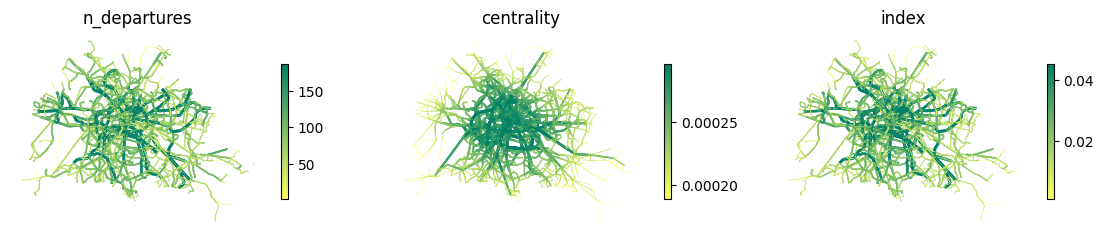

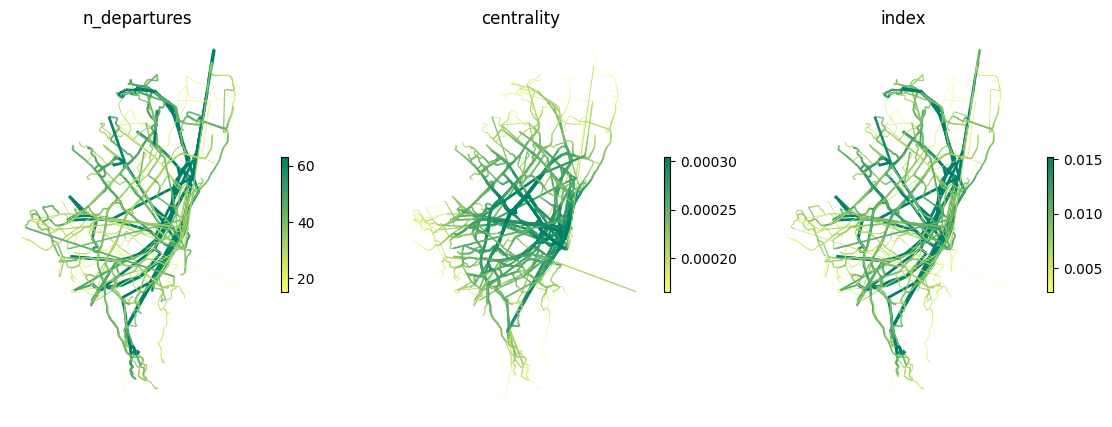

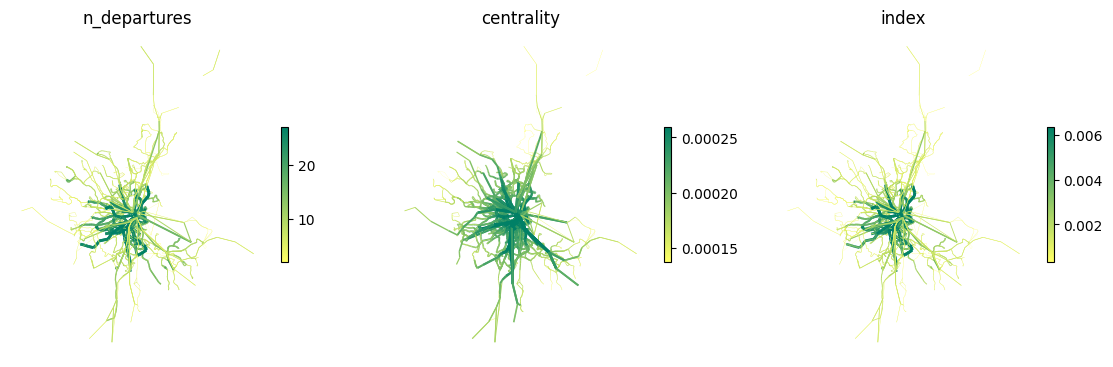

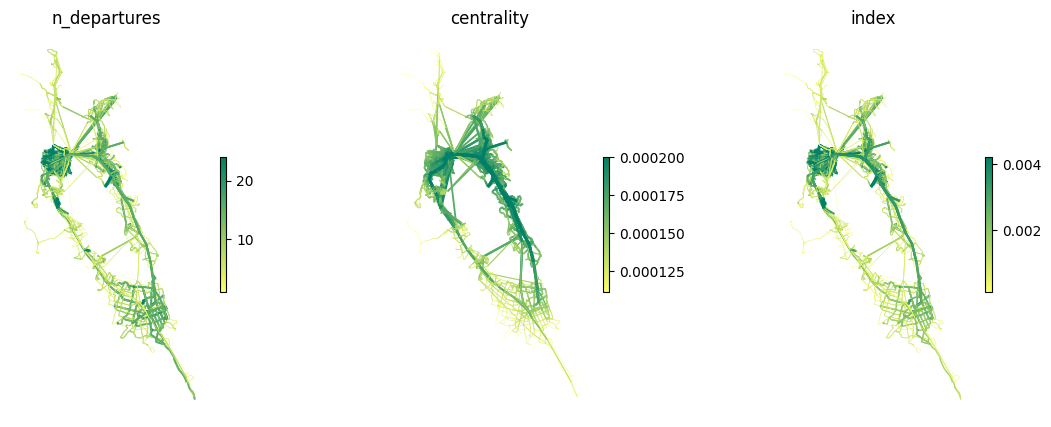

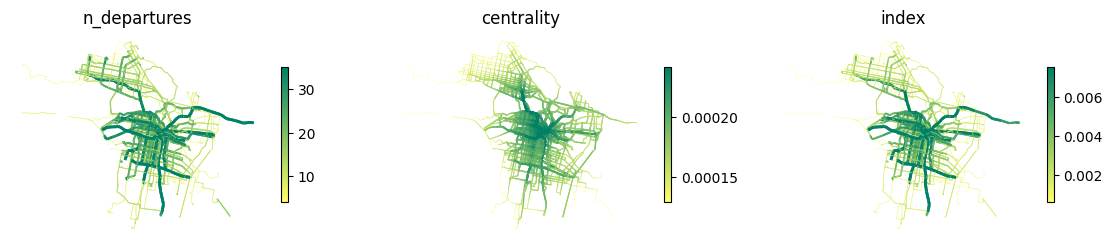

In [103]:
%matplotlib inline

graphs = [G_ber, G_bog, G_bos, G_sf, G_lax]
for G in graphs:
    plot_index_composition(G)

#### Validation: Exemplary routing according to underlying transit graph 

In [41]:
1 / 0.00015 / 60

111.11111111111111

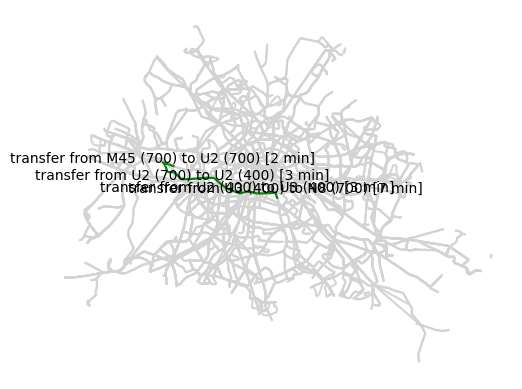

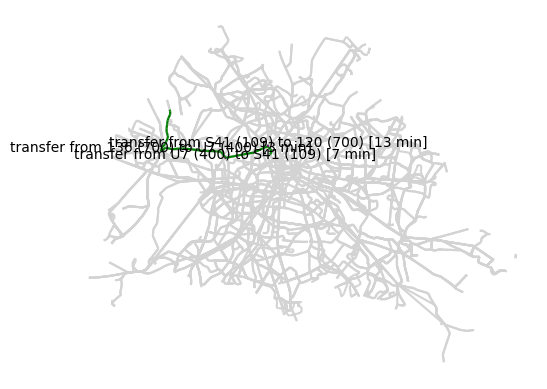

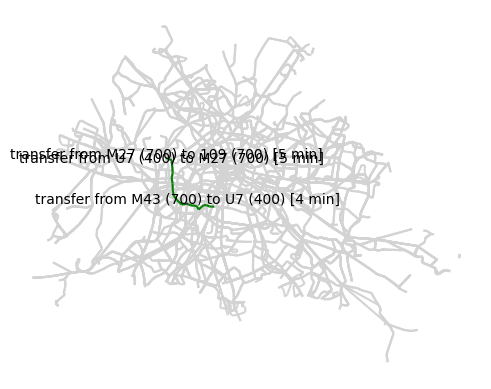

In [111]:
for _ in range(3):
    plot_route(G, random.randint(0, 3000), random.randint(0, 3000))
    plt.show()

### Calculating TransitAccess scores

#### Location

In [77]:
# G = ox.project_graph(G_ber)
# berlin_loc = gpd.GeoSeries.from_xy([13.351798027529089], [52.49615200183667], crs='EPSG:4326').to_crs(G.graph['crs'])
# score.transit_access(G, berlin_loc)

loc_bog = gpd.GeoSeries.from_xy([-74.09887356139066], [4.668790609810458], crs='EPSG:4326').to_crs(G_bog.graph['crs'])
score.transit_access(G_bog, loc_bog)

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/osmnx/utils_graph.py:88: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_edges["geometry"] = np.nan
/Users/fnachtigall/workspace/transit-access/demo/../transit_access/score.py:85: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  access_to_each_stop['route_id_w_direction'] = access_to_each_stop.index.str.split(network.ID_SEP, 1).str[1]


0    0.357034
dtype: float64

#### Grid

In [135]:
access_score_grid = score.transit_access_for_grid(G_bog, h3_res=8)
access_score_grid.explore('access_score')
access_score_grid.h3.h3_to_parent_aggregate(7, operation='mean').explore('access_score')

2023-08-15 18:27:52,544 | INFO | Calculating TransitAccess index for convex hull with 2km buffer around transit stops.


/Users/fnachtigall/workspace/transit-access/demo/../transit_access/score.py:143: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  access_to_each_stop['route_id_w_direction'] = access_to_each_stop.index.str.split(network.ID_SEP, 1).str[1]


In [391]:
with open('../data/access-score-grid-Bogota.pkl', 'rb') as f:
    score_bog = pickle.load(f)

#### Neighborhood

In [87]:
G = ox.project_graph(G_ber)
nbh = gpd.read_file('../data/zip-codes-berlin.geojson').to_crs(G.graph['crs'])
access_score_nbh = score.transit_access_for_neighborhood(G, nbh)
access_score_nbh.explore('access_score', legend=True)

/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/osmnx/utils_graph.py:88: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_edges["geometry"] = np.nan
/Users/fnachtigall/workspace/transit-access/demo/../transit_access/score.py:85: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  access_to_each_stop['route_id_w_direction'] = access_to_each_stop.index.str.split(network.ID_SEP, 1).str[1]


In [98]:
# HELPER FUNCTIONS

import matplotlib.colors as colors
import random

def scale_to_range(s, vmin, vmax):
    old_range = s.max() - s.min()
    new_range = vmax - vmin
    return ((s - s.min()) / old_range * new_range) + vmin


def plot_route(G, from_idx, to_idx):
    nodes, edges = graph_to_gdfs(nx.DiGraph(G))

    route = nx.shortest_path(G, nodes.index[from_idx], nodes.index[to_idx], weight='weight')
    route_edges = edges.loc[list(zip(route, route[1:], [0] * len(route)))]
    route_transfers = route_edges[route_edges['mode'] == 'walk'].reset_index()

    ax = edges[edges['mode'] != 'walk'].plot(color='lightgrey')
    route_edges.plot(color='green', ax=ax)
    route_transfers.plot(color='purple', ax=ax)
    route_transfers.apply(lambda x: ax.annotate(text=f"transfer from {nodes.loc[x['u']]['route_short_name']} ({nodes.loc[x['u']]['route_type']}) " +
                                                        f"to {nodes.loc[x['v']]['route_short_name']} ({nodes.loc[x['v']]['route_type']}) " +
                                                        f"[{int(x['weight'] / 60)} min]", xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

    # route_transfers.apply(lambda x: ax.annotate(text=f"{nodes.loc[x['u']]['stop_name'] if 'stop_name' in nodes.columns else ''}\n \
    #                                             transfer from {nodes.loc[x['u']]['route_short_name']} ({nodes.loc[x['u']]['route_type']}) to {nodes.loc[x['v']]['route_short_name']} ({nodes.loc[x['v']]['route_type']}) \n \
    #                                                 {int((x['weight'] - nodes.loc[x['v']]['headaway'] / 2) / 60)} min walking and {int(nodes.loc[x['v']]['headaway'] / 2 / 60)} min waiting",
    #                                                 xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
                                                    # {int(x['walk_time'] / 60)} min walking and {int(x['headaway'] / 60)} min waiting",
    ax.set_axis_off()



def plot_networkx(G):
    locations = list(zip([int(x) for x in nx.get_node_attributes(G, 'x').values()], [int(x) for x in nx.get_node_attributes(G, 'y').values()]))
    nx.draw(G, locations)


def perturb_geom(geom):
    return geom.apply(lambda x: shapely.affinity.translate(x, xoff=random.randint(-100, 100)/1000000, yoff=random.randint(-100, 100)/1000000))


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def plot_index_composition(G):
    G = G.copy()
    mm.mean_nodes(G, 'centrality')
    mm.mean_nodes(G, 'n_departures')
    edges = edges_to_gdf(nx.DiGraph(G))
    edges['index'] = edges['n_departures'] * edges['centrality'] 
    from sklearn.preprocessing import StandardScaler
    edges['index2'] = np.nanmean(StandardScaler().fit_transform(edges[['centrality', 'n_departures']]), axis=1)
    _, axs = plt.subplots(ncols=4, figsize=(14, 5))
    plot_edge_attr(edges, 'n_departures', ax=axs[0])
    plot_edge_attr(edges, 'centrality', ax=axs[1])
    plot_edge_attr(edges, 'index', ax=axs[2])
    plot_edge_attr(edges, 'index2', ax=axs[3])


def plot_edge_attr(edges, attr, ax=None):
    edges = edges[edges['mode'] != 'walk']
    vmin, vmax = edges[attr].quantile([.05, .95])

    edges[attr] = edges[attr].mask(edges[attr] > vmax, vmax)
    edges[attr] = edges[attr].mask(edges[attr] < vmin, vmin)
    linewidth = scale_to_range(edges[attr], 0.1, 2)
    
    ax = edges.plot(column=attr, vmin=vmin, vmax=vmax, linewidth=linewidth, cmap='summer_r', legend=True, legend_kwds={'shrink': 0.35}, ax=ax)
    ax.set_axis_off()
    ax.set_title(attr)


def plot_network_combined_attr(G):
    G = G.copy()
    mm.mean_nodes(G, 'route_type')
    mm.mean_nodes(G, 'n_departures')
    nodes, edges = graph_to_gdfs(nx.DiGraph(G))
    vmin, vmax = edges['n_departures'].quantile([.1, .9])
    c_vmin, c_vmax = nodes['centrality'].quantile([.1, .9])
    # ax = edges.plot(column='route_type', linewidth=0.5, categorical=True, legend=True)
    # nodes.plot('n_departures', vmin=vmin, vmax=vmax, markersize=nodes['n_departures'], legend=True, cmap='RdYlGn', ax=ax)
    cmap_p = truncate_colormap(plt.get_cmap('PuBu'), 0.2, 1)
    cmap_g = truncate_colormap(plt.get_cmap('Greens'), 0.4, 1)
    ax = edges[edges['mode'] != 'walk'].plot(column='n_departures', vmin=vmin, vmax=vmax, linewidth=scale_to_range(edges['n_departures'], 0.1, 5), cmap=cmap_p, legend=True)
    # ax = edges[edges['mode'] != 'walk'].plot(color='grey', linewidth=scale_to_range(edges['n_departures'], 0.1, 5), legend=True)
    nodes.plot(column='centrality',  vmin=c_vmin, vmax=c_vmax, cmap='YlGn', markersize=0.75, legend=True, ax=ax)
    # nodes.plot(color='grey', legend=True, ax=ax)
    ax.set_axis_off()


def plot_network_centrality(G):
    G = G.copy()
    mm.mean_nodes(G, 'route_type')
    mm.mean_nodes(G, 'centrality')
    mm.mean_nodes(G, 'closeness_centrality')
    nodes, edges = graph_to_gdfs(nx.DiGraph(G))
    markersize = scale_to_range(nodes['n_departures'], 1, 20)
    # ax = edges[edges['mode'] != 'walk'].plot(column='route_type', linewidth=0.5, categorical=True, legend=True)
    # nodes.plot('centrality', legend=True, cmap='RdYlGn', ax=ax)
    # nodes.plot('centrality', legend=True, markersize=markersize, cmap='RdYlGn', ax=ax)

    ax = edges.plot(column='centrality',  cmap='RdYlGn', legend=True)
    nodes.plot(markersize=markersize, color='grey', legend=True, ax=ax)
    plt.show()
    ax = edges.plot(column='closeness_centrality',  cmap='RdYlGn', legend=True)
    nodes.plot(markersize=markersize, color='grey', legend=True, ax=ax)
    ax.set_axis_off()


def plot_network_index(G):
    G = G.copy()
    mm.mean_nodes(G, 'centrality')
    mm.mean_nodes(G, 'n_departures')
    nodes, edges = graph_to_gdfs(nx.DiGraph(G))
    edges['index'] = edges['n_departures'] * edges['centrality'] 
    # ax = edges.plot(column='route_type', categorical=True, legend=True)
    # nodes.plot('centrality', markersize=nodes['n_departures'], legend=True, cmap='RdYlGn', ax=ax)
    ax = edges.plot(column='index',  cmap='RdYlGn', legend=True)
    nodes.plot(color='grey', legend=True, ax=ax)


def plot_graph(G, add_noise=False):
    G_lax = G.copy()
    mm.mean_nodes(G_lax, 'route_type')
    nodes, edges = graph_to_gdfs(nx.DiGraph(G))
    edges['route_type'] = edges['route_type'].map({109: 'S-Bahn', 400: 'metro', 700: 'bus', 900: 'tram'})

    colors = ['plum', 'thistle', 'lavenderblush', 'paleturquoise', 'mediumturquoise']
    cmap = matplotlib.colors.ListedColormap(colors)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['thistle', 'cadetblue'])

    if add_noise:
        edges['geometry'] = perturb_geom(edges['geometry'])
        nodes['geometry'] = perturb_geom(nodes['geometry'])

    if 'mode' in edges.columns:
        ax = edges[(edges['mode'] != 'walk') & (edges['route_type'] != 'bus')].plot(column='route_type', legend=True)
        edges[edges['route_type'] == 'bus'].plot(color='grey', linewidth=0.5, linestyle=':', legend=True, ax=ax)
        edges[edges['mode'] == 'walk'].plot(column='weight', legend=True, cmap='Greens_r', vmax=600, ax=ax)
    else:
        ax = edges.plot(column='route_type', categorical=True, legend=True)

    if 'centrality' in nodes.columns:
        # nodes.plot('centrality', markersize=nodes['n_departures']/5, legend=True, cmap='RdYlGn', ax=ax)
        nodes.plot('centrality', markersize=nodes['n_departures'], legend=True, cmap='RdYlGn', ax=ax)
    else:
        nodes.plot('headaway', vmax=1800, legend=True, ax=ax)
    ax.set_axis_off()



#### Analysis of closeness centrality & TransitAccess score by transport mode

In [92]:
nodes, edges = ox.utils_graph.graph_to_gdfs(G)
nodes['index'] = nodes['n_departures'] * nodes['centrality'] 

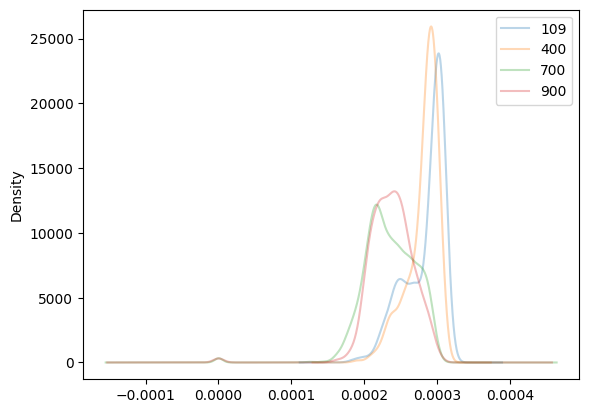

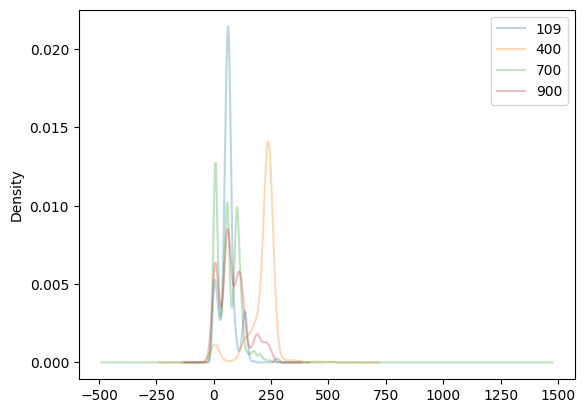

In [91]:
%matplotlib inline

nodes.groupby('route_type')['centrality'].plot.density(alpha=0.3, legend=True)
plt.show()

nodes.groupby('route_type')['n_departures'].plot.density(alpha=0.3, legend=True)
plt.show()

# nodes.groupby('route_type')['n_departures'].hist(alpha=0.3, bins=10, density=True, legend=True)
# nodes.groupby('route_type')['centrality'].hist(alpha=0.3, bins=20, density=True, legend=True)

#### Headaway and walking transfer times

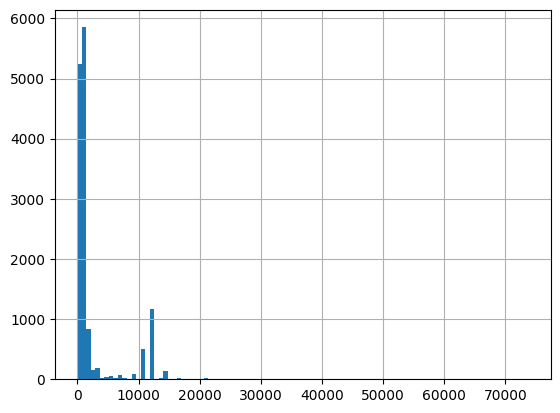

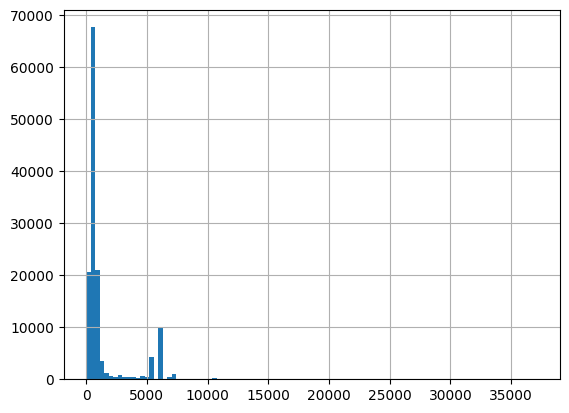

In [96]:
%matplotlib inline

nodes['headaway'].hist(bins=100)
plt.show()

edges[edges['mode'] == 'walk']['weight'].hist(bins=100)
plt.show()

In [115]:
%matplotlib qt
with open('../data/transit-network-connectivity-Rio-20230815-15-52-14.pkl', 'rb') as f:
    G_rio = pickle.load(f)

plot_network_centrality(G_rio)